<a href="https://colab.research.google.com/github/nonyeezeh/Research-Project-Code/blob/main/code_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [3]:
!pip install pgmpy

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [16]:
import numpy as np
from tabulate import tabulate
import pandas as pd
import networkx as nx
import plotly.graph_objects as go

import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder

from pgmpy.estimators import HillClimbSearch, BicScore, MaximumLikelihoodEstimator
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

# Research Question

##### In this research, how does the predictive accuracy of a neural network compare to that of a Bayesian network in predicting stock prices, particularly when trained on varying sample sizes of data generated by a Bayesian network?

# Expectations

1. With larger training samples, the neural network's performance is expected to improve due to having sufficient data for effective learning, while the Bayesian network may outperform the neural network on smaller samples.
2. The Bayesian network is anticipated to show more consistent performance across different sample sizes due to its probabilistic nature and reliance on prior knowledge.
3. The neural network might require more computational resources and time to train, especially with increasing sample sizes, compared to the Bayesian network.

# Ground Truth

## Bayesian Network Data Generation

In [6]:
# Define the number of samples
num_samples = 50

# Define the possible values for each variable
values = {
    'IR': ['low', 'medium', 'high'],
    'EI': ['poor', 'average', 'good'],
    'SP': ['decrease', 'stable', 'increase']
}

#-------------------------------------------------------------------------------

#Normal Data Generation
# Functions to sample each variable with probabilities
# def sample_IR():
#     probabilities = np.random.dirichlet(np.ones(len(values['IR'])))
#     rounded_probs = [round(p, 2) for p in probabilities]
#     chosen_index = np.argmax(probabilities)
#     chosen_value = values['IR'][chosen_index]
#     return chosen_value, rounded_probs

# def sample_EI(ir=None):
#     probabilities = np.random.dirichlet(np.ones(len(values['EI'])))
#     rounded_probs = [round(p, 2) for p in probabilities]
#     chosen_index = np.argmax(probabilities)
#     chosen_value = values['EI'][chosen_index]
#     return chosen_value, rounded_probs

# def sample_SP(ir, ei):
#     # Generate probabilities based on a joint influence of IR and EI
#     probabilities = np.random.dirichlet(np.ones(len(values['SP'])))
#     rounded_probs = [round(p, 2) for p in probabilities]
#     chosen_index = np.argmax(probabilities)
#     chosen_value = values['SP'][chosen_index]
#     return chosen_value, rounded_probs

#-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------

#Introducing Noise
# Define a function to add Gaussian noise
def add_noise(probabilities, noise_level=0.05):
    noisy_probs = probabilities + np.random.normal(0, noise_level, len(probabilities))
    noisy_probs = np.clip(noisy_probs, 0, 1)  # Ensure probabilities are within [0, 1]
    noisy_probs /= noisy_probs.sum()  # Normalize to ensure they sum to 1
    return noisy_probs

def sample_IR():
    probabilities = np.random.dirichlet(np.ones(len(values['IR'])))
    probabilities = add_noise(probabilities, noise_level=0.05)  # Add noise
    rounded_probs = [round(p, 2) for p in probabilities]
    chosen_index = np.argmax(probabilities)
    chosen_value = values['IR'][chosen_index]
    return chosen_value, rounded_probs

def sample_EI(ir=None):
    probabilities = np.random.dirichlet(np.ones(len(values['EI'])))
    probabilities = add_noise(probabilities, noise_level=0.05)  # Add noise
    rounded_probs = [round(p, 2) for p in probabilities]
    chosen_index = np.argmax(probabilities)
    chosen_value = values['EI'][chosen_index]
    return chosen_value, rounded_probs

def sample_SP(ir, ei):
    probabilities = np.random.dirichlet(np.ones(len(values['SP'])))
    probabilities = add_noise(probabilities, noise_level=0.05)  # Add noise
    rounded_probs = [round(p, 2) for p in probabilities]
    chosen_index = np.argmax(probabilities)
    chosen_value = values['SP'][chosen_index]
    return chosen_value, rounded_probs

#-------------------------------------------------------------------------------

# Randomly determine the structure (edges)
edges = []
if np.random.rand() > 0.5:
    edges.append(('IR', 'EI'))
if np.random.rand() > 0.5:
    edges.append(('EI', 'IR'))
if np.random.rand() > 0.5:
    edges.append(('IR', 'SP'))
if np.random.rand() > 0.5:
    edges.append(('EI', 'SP'))

# Ensure there's at least one edge to SP (either from IR or EI)
if not any(edge[1] == 'SP' for edge in edges):
    edges.append(np.random.choice([('IR', 'SP'), ('EI', 'SP')]))

# Generate the data and capture probabilities
data = []
probabilities_data = []

for _ in range(num_samples):
    ir, ir_probs = sample_IR()
    ei, ei_probs = sample_EI(ir)
    sp, sp_probs = sample_SP(ir, ei)

    data.append([ir, ei, sp])
    probabilities_data.append([
        ','.join(map(str, ir_probs)),
        ir,
        ','.join(map(str, ei_probs)),
        ei,
        ','.join(map(str, sp_probs)),
        sp
    ])

# Convert to DataFrame for the main data
df = pd.DataFrame(data, columns=['IR', 'EI', 'SP'])

# Save the main data to a CSV file
df.to_csv('bn_data_structure.csv', index=False)

# Convert to DataFrame for probabilities and chosen values
probabilities_df = pd.DataFrame(probabilities_data, columns=[
    'IR_Probabilities', 'Chosen_IR',
    'EI_Probabilities', 'Chosen_EI',
    'SP_Probabilities', 'Chosen_SP'
])

# Save the probabilities and chosen values to a CSV file
#probabilities_df.to_csv('bn_probabilities.csv', index=False)

# Display the DataFrame as a fancy table
print("\nProbabilities and chosen values:")
print(tabulate(probabilities_df.head(), headers='keys', tablefmt='fancy_grid'))

#-----------------------------------------------------------------------------------------------------

# Extract the necessary columns from the probabilities_df DataFrame
test_data = probabilities_df[['Chosen_IR', 'Chosen_EI', 'Chosen_SP']]

# Find the SP Probability corresponding to the chosen SP
test_data['SP_Probability'] = probabilities_df.apply(
    lambda row: float(row['SP_Probabilities'].split(',')[values['SP'].index(row['Chosen_SP'])]),
    axis=1
)

# Rename the columns to match the intended output format
test_data.rename(columns={
    'Chosen_IR': 'IR',
    'Chosen_EI': 'EI',
    'Chosen_SP': 'SP'
}, inplace=True)

# Save the test data to a new CSV file with only the specified columns
test_data.to_csv('bn_test_data_for_NN.csv', index=False)

# Print confirmation
print("Test data saved successfully as bn_test_data_for_NN.csv.")


Probabilities and chosen values:
╒════╤════════════════════╤═════════════╤════════════════════╤═════════════╤════════════════════╤═════════════╕
│    │ IR_Probabilities   │ Chosen_IR   │ EI_Probabilities   │ Chosen_EI   │ SP_Probabilities   │ Chosen_SP   │
╞════╪════════════════════╪═════════════╪════════════════════╪═════════════╪════════════════════╪═════════════╡
│  0 │ 0.16,0.19,0.65     │ high        │ 0.57,0.0,0.43      │ poor        │ 0.11,0.37,0.51     │ increase    │
├────┼────────────────────┼─────────────┼────────────────────┼─────────────┼────────────────────┼─────────────┤
│  1 │ 0.04,0.0,0.96      │ high        │ 0.26,0.08,0.66     │ good        │ 0.05,0.74,0.21     │ stable      │
├────┼────────────────────┼─────────────┼────────────────────┼─────────────┼────────────────────┼─────────────┤
│  2 │ 0.14,0.38,0.48     │ high        │ 0.3,0.54,0.16      │ average     │ 0.11,0.29,0.6      │ increase    │
├────┼────────────────────┼─────────────┼────────────────────┼────────

<ipython-input-6-9e89ff372464>:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['SP_Probability'] = probabilities_df.apply(
<ipython-input-6-9e89ff372464>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.rename(columns={


In [7]:
# Visualize the Bayesian Network structure using Plotly
G = nx.DiGraph()

# Add nodes and edges
G.add_edges_from(edges)

# Extract node positions for Plotly
pos = nx.spring_layout(G)
edge_x = []
edge_y = []
arrow_x = []
arrow_y = []

for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

    # Move arrows closer to the target node (x1, y1)
    arrow_x.append(0.90 * x1 + 0.10 * x0)
    arrow_y.append(0.90 * y1 + 0.10 * x0)


edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=2, color='gray'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
node_text = []
node_hovertext = []
node_color = []

for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(node)

    # Customize hover text for each node
    if node == 'IR':
        node_hovertext.append('Interest Rates')
    elif node == 'EI':
        node_hovertext.append('Economic Indicators')
    elif node == 'SP':
        node_hovertext.append('Stock Price')
    else:
        node_hovertext.append(node)

    # Highlight the SP node with a different color
    if node == 'SP':
        node_color.append('pink')
    else:
        node_color.append('purple')

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=node_text,
    textposition="top center",
    hoverinfo='text',
    hovertext=node_hovertext,
    marker=dict(size=50, color=node_color, line=dict(width=2)))

# Adding the arrow heads, placing them correctly outside the nodes
#arrow_trace = go.Scatter(
    #x=arrow_x, y=arrow_y,
    #mode='markers',
    #marker=dict(size=10, color='black', symbol='triangle-up'),
    #hoverinfo='none'
#)

#fig = go.Figure(data=[edge_trace, node_trace, arrow_trace],
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20, l=20, r=20, t=50),  # Adjusted margins to fit the title
                xaxis=dict(showgrid=False, zeroline=False),
                yaxis=dict(showgrid=False, zeroline=False),
                plot_bgcolor='aliceblue')
                )

# Update layout to include a proper title
fig.update_layout(title_text="Bayesian Network Structure", title_x=0.5)

fig.show()

# Neural Network

## Neural Network Training

In [8]:
# Load the data
data = pd.read_csv('bn_data_structure.csv')

# Preprocess the data
# One-hot encode IR and EI using a separate encoder
encoder_X = OneHotEncoder(sparse=False)
X = encoder_X.fit_transform(data[['IR', 'EI']])

# One-hot encode SP with a specific order of categories
encoder_y = OneHotEncoder(sparse=False, categories=[['decrease', 'stable', 'increase']])
y = encoder_y.fit_transform(data[['SP']])

# Build and train the neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, input_dim=X.shape[1], activation='relu'), # 30 nodes in hidden layer
    #tf.keras.layers.Dense(25, input_dim=X.shape[1], activation='relu'),  # More neurons, additional layer
    #tf.keras.layers.Dense(40, activation='relu'),  # Additional layer, more neurons
    #tf.keras.layers.Dense(15, input_dim=X.shape[1], activation='relu'),  # More neurons, additional layer
    #tf.keras.layers.Dense(10, activation='relu'),  # Additional layer, more neurons
    tf.keras.layers.Dense(y.shape[1], activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.fit(X, y, epochs=50, batch_size=16, verbose=1)  # Train with 50 epochs
#model.fit(X, y, epochs=100, batch_size=16, verbose=1)  # Train with 100 epochs
model.fit(X, y, epochs=20, batch_size=10, verbose=1)  # Train with 50 epochs

# Get predicted probabilities from the NN
y_pred_probs = model.predict(X)

# Convert probabilities to predicted SP categories
y_pred = np.argmax(y_pred_probs, axis=1)

# Use numpy to map the indices to the actual category labels
predicted_sp = np.array(encoder_y.categories_[0])[y_pred]

# Get the final probability for the predicted SP
predicted_sp_probs = [y_pred_probs[i, idx] for i, idx in enumerate(y_pred)]

# Prepare the output DataFrame
output_df = pd.DataFrame({
    'IR': data['IR'],
    'EI': data['EI'],
    'Actual SP': data['SP'],
    'Predicted SP': predicted_sp,
    'Predicted SP Probability': predicted_sp_probs
})

# Display the first 10 rows of the output
print(output_df.head(10))

# Optionally save the output to a CSV file
output_df.to_csv('nn_output_with_probabilities.csv', index=False)

# Display the full range of predicted probabilities as a separate output
print("\nFull Range of Predicted SP Probabilities:")
for i in range(10):  # Display the first 10 rows for brevity
    print(f"Sample {i+1} - IR: {data['IR'].iloc[i]}, EI: {data['EI'].iloc[i]}")
    print(f"Predicted SP Probabilities: {y_pred_probs[i]}")
    print(f"Actual SP: {data['SP'].iloc[i]}, Predicted SP: {predicted_sp[i]}")
    print("------")

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.2294 - loss: 1.1372
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.2581 - loss: 1.1513
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2858 - loss: 1.1377
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3706 - loss: 1.0985
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2831 - loss: 1.1238 
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3608 - loss: 1.1067 
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3303 - loss: 1.0980
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2664 - loss: 1.1338  
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3150 - loss: 1.1127
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2636 - loss: 1.1133  
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3094 - loss: 1.1094
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2872 - loss: 1.1067

## NN and BN (Ground Truth) MSE

In [9]:
# Load the test data with BN probabilities
bn_test_data = pd.read_csv('bn_test_data_for_NN.csv')

# Load the NN output data with NN probabilities
nn_output_data = pd.read_csv('nn_output_with_probabilities.csv')

# Ensure the data is aligned by checking for matching IR, EI, and SP
assert np.all(bn_test_data['IR'] == nn_output_data['IR'])
assert np.all(bn_test_data['EI'] == nn_output_data['EI'])
assert np.all(bn_test_data['SP'] == nn_output_data['Actual SP'])

# Calculate the squared differences between BN and NN probabilities
bn_prob = bn_test_data['SP_Probability']
nn_prob = nn_output_data['Predicted SP Probability']
squared_diffs = (bn_prob - nn_prob) ** 2

# Combine the relevant columns into a DataFrame for display
comparison_df = pd.DataFrame({
    'BN Probability': bn_prob,
    'NN Probability': round(nn_prob,3),
    'Squared Difference': round(squared_diffs,3)
})

# Display the first few rows to see the comparison
print("Comparison of BN and NN probabilities (first few rows):")
print(comparison_df.head(10))

# Calculate the Mean Squared Error (MSE)
mse = squared_diffs.mean()

# Display the MSE value
print(f"\nMean Squared Error (MSE) between BN and NN probabilities: {round(mse,3)}")

Comparison of BN and NN probabilities (first few rows):
   BN Probability  NN Probability  Squared Difference
0            0.51           0.380               0.017
1            0.74           0.357               0.147
2            0.60           0.420               0.032
3            0.59           0.361               0.052
4            0.52           0.361               0.025
5            0.62           0.402               0.048
6            0.77           0.371               0.159
7            0.42           0.361               0.003
8            0.82           0.420               0.160
9            0.68           0.357               0.104

Mean Squared Error (MSE) between BN and NN probabilities: 0.06


# Learned BN

In [10]:
import pandas as pd

# Load the NN output data
nn_output_data = pd.read_csv('nn_output_with_probabilities.csv')

# Load the ground truth BN probabilities
bn_test_data = pd.read_csv('bn_test_data_for_NN.csv')

# Display the first few rows of each dataset to ensure they are loaded correctly
print("NN Output Data:")
print(nn_output_data.head())

print("\nGround Truth BN Data:")
print(bn_test_data.head())

NN Output Data:
     IR       EI Actual SP Predicted SP  Predicted SP Probability
0  high     poor  increase     decrease                  0.379616
1  high     good    stable     increase                  0.357223
2  high  average  increase     increase                  0.419964
3   low  average  increase       stable                  0.361455
4   low  average  decrease       stable                  0.361455

Ground Truth BN Data:
     IR       EI        SP  SP_Probability
0  high     poor  increase            0.51
1  high     good    stable            0.74
2  high  average  increase            0.60
3   low  average  increase            0.59
4   low  average  decrease            0.52


In [22]:
# Load the NN output data
nn_output_data = pd.read_csv('nn_output_with_probabilities.csv')

# Extract the relevant columns: IR, EI, and NN Predicted SP
bayesian_learning_data = nn_output_data[['IR', 'EI', 'Predicted SP']]

# Rename 'Predicted SP' to 'SP' to match the target variable name
bayesian_learning_data.rename(columns={'Predicted SP': 'SP'}, inplace=True)

# Display the extracted data
print("Extracted Data for Bayesian Network Learning (predictions from NN):")
print(bayesian_learning_data.head())

# Save the extracted data to a CSV file
bayesian_learning_data.to_csv('bayesian_learning_data_from_nn.csv', index=False)

print("\nData saved successfully to 'bayesian_learning_data_from_nn.csv'")

Extracted Data for Bayesian Network Learning (predictions from NN):
     IR       EI        SP
0  high     poor  decrease
1  high     good  increase
2  high  average  increase
3   low  average    stable
4   low  average    stable

Data saved successfully to 'bayesian_learning_data_from_nn.csv'


<ipython-input-22-2d38d0f2942e>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [23]:
# Learn the BN structure using Hill Climb Search and BIC
hc = HillClimbSearch(bayesian_learning_data)
learned_model = hc.estimate(scoring_method=BicScore(bayesian_learning_data))

# Display the learned structure (edges)
print("Learned BN Structure:")
print(learned_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

Learned BN Structure:
[('EI', 'SP'), ('SP', 'IR')]


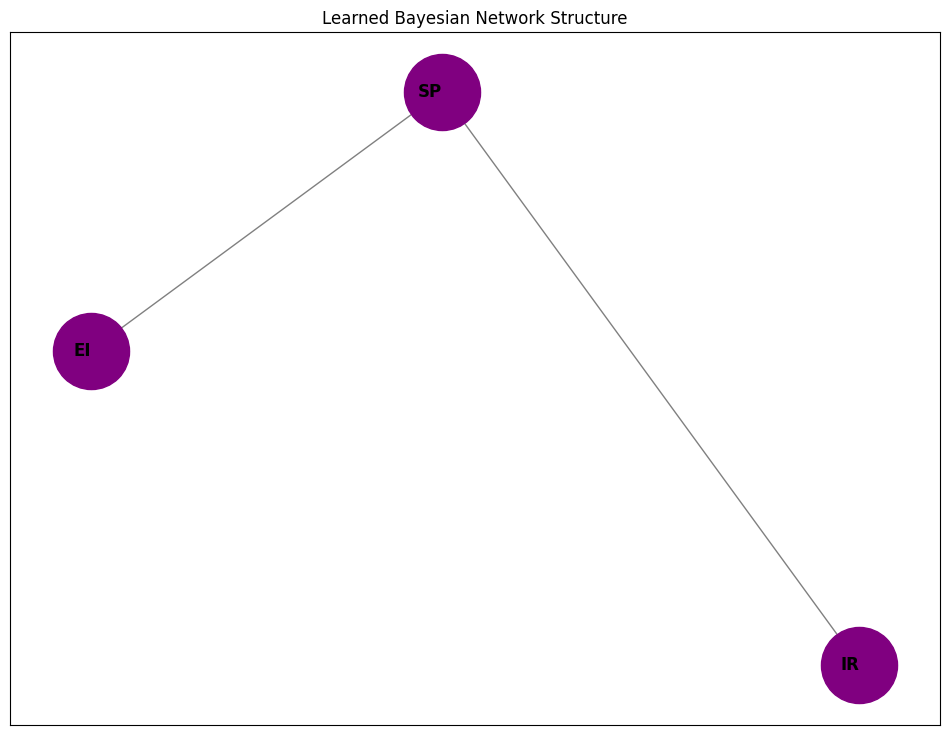

In [24]:
# Create a directed graph from the learned BN structure
G = nx.DiGraph()

# Add edges to the graph
G.add_edges_from(learned_model.edges())

# Draw the graph using Matplotlib
plt.figure(figsize=(12, 9))  # Increase figure size for better readability
pos = nx.spring_layout(G)  # Positioning the nodes

# Draw nodes, edges, and labels
nx.draw_networkx_nodes(G, pos, node_color='purple', node_size=3000)
nx.draw_networkx_edges(G, pos, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=12, font_color='black', font_weight='bold', verticalalignment='center', horizontalalignment='right')

# Show the plot
plt.title("Learned Bayesian Network Structure")
plt.show()

In [26]:
# Fit the BN parameters using Maximum Likelihood Estimation
learned_bn = BayesianNetwork(learned_model.edges())
learned_bn.fit(bayesian_learning_data, estimator=MaximumLikelihoodEstimator)

print("BN parameters have been fitted.")

BN parameters have been fitted.


In [36]:
# Initialize the inference object
infer = VariableElimination(learned_bn)

# Function to get the probability distribution for SP
def get_sp_probability(row):
    query_result = infer.query(variables=['SP'], evidence={'IR': row['IR'], 'EI': row['EI']})
    return query_result.values

# Apply the function to get the probabilities for each row
bayesian_learning_data['Learned_BN_Probabilities'] = bayesian_learning_data.apply(get_sp_probability, axis=1)

# Get the predicted SP by taking the argmax of the probabilities
bayesian_learning_data['Learned_BN_Predicted_SP'] = bayesian_learning_data['Learned_BN_Probabilities'].apply(
    lambda probs: ['decrease', 'stable', 'increase'][np.argmax(probs)]
)

# Extract the correct final probability corresponding to the predicted SP
bayesian_learning_data['Learned_BN_SP_Probability'] = bayesian_learning_data.apply(
    lambda row: row['Learned_BN_Probabilities'][['decrease', 'stable', 'increase'].index(row['Learned_BN_Predicted_SP'])],
    axis=1
)

# Round the probabilities in the Learned_BN_Probabilities column to 2 decimal places
bayesian_learning_data['Learned_BN_Probabilities'] = bayesian_learning_data['Learned_BN_Probabilities'].apply(
    lambda probs: [round(prob, 2) for prob in probs]
)

# Round the final predicted SP probability as well
bayesian_learning_data['Learned_BN_SP_Probability'] = bayesian_learning_data['Learned_BN_SP_Probability'].round(2)

# Display the updated data with the learned probabilities
print("Updated Data with Corrected and Rounded Learned BN Probabilities:")
print(bayesian_learning_data.head())

Updated Data with Corrected and Rounded Learned BN Probabilities:
     IR       EI        SP Learned_BN_Probabilities Learned_BN_Predicted_SP  \
0  high     poor  decrease          [1.0, 0.0, 0.0]                decrease   
1  high     good  increase        [0.19, 0.81, 0.0]                  stable   
2  high  average  increase          [0.0, 1.0, 0.0]                  stable   
3   low  average    stable          [0.0, 0.0, 1.0]                increase   
4   low  average    stable          [0.0, 0.0, 1.0]                increase   

   Learned_BN_SP_Probability  
0                       1.00  
1                       0.81  
2                       1.00  
3                       1.00  
4                       1.00  


In [37]:
# Load the ground truth probabilities from the original BN
ground_truth_data = pd.read_csv('bn_test_data_for_NN.csv')

# Display the ground truth data to confirm
print("Ground Truth BN Data:")
print(ground_truth_data.head())

Ground Truth BN Data:
     IR       EI        SP  SP_Probability
0  high     poor  increase            0.51
1  high     good    stable            0.74
2  high  average  increase            0.60
3   low  average  increase            0.59
4   low  average  decrease            0.52


In [41]:
# Load the ground truth probabilities from the original BN file
ground_truth_data = pd.read_csv('bn_test_data_for_NN.csv')

# Load the learned BN data that contains the learned probabilities
learned_bn_data = bayesian_learning_data  # Assuming bayesian_learning_data is already available

# Extract the original BN SP probabilities
original_sp_probabilities = ground_truth_data['SP_Probability']

# Extract the learned BN SP probabilities
learned_sp_probabilities = learned_bn_data['Learned_BN_SP_Probability']

# Create a new DataFrame to compare the original and learned probabilities
comparison_df = pd.DataFrame({
    'Original BN SP Probability': original_sp_probabilities,
    'Learned BN SP Probability': learned_sp_probabilities
})

# Display the comparison
print("Comparison of Original and Learned BN SP Probabilities:")
print(comparison_df.head(10))

# Save the comparison to a CSV file
comparison_df.to_csv('sp_probabilities_comparison.csv', index=False)
print("Comparison saved to 'sp_probabilities_comparison.csv'")

Comparison of Original and Learned BN SP Probabilities:
   Original BN SP Probability  Learned BN SP Probability
0                        0.51                       1.00
1                        0.74                       0.81
2                        0.60                       1.00
3                        0.59                       1.00
4                        0.52                       1.00
5                        0.62                       1.00
6                        0.77                       0.52
7                        0.42                       1.00
8                        0.82                       1.00
9                        0.68                       1.00
Comparison saved to 'sp_probabilities_comparison.csv'


In [42]:
# Load the comparison file that contains both original and learned BN SP probabilities
comparison_df = pd.read_csv('sp_probabilities_comparison.csv')

# Calculate the squared differences between the original BN and learned BN probabilities
comparison_df['Squared Difference'] = (comparison_df['Original BN SP Probability'] - comparison_df['Learned BN SP Probability']) ** 2

# Display the first few rows to see the comparison with squared differences
print("Comparison of Original BN and Learned BN probabilities (first few rows):")
print(comparison_df[['Original BN SP Probability', 'Learned BN SP Probability', 'Squared Difference']].head(10))

# Calculate the Mean Squared Error (MSE)
mse_learned_vs_original_bn = comparison_df['Squared Difference'].mean()

# Display the MSE value
print(f"\nMean Squared Error (MSE) between Ground Truth BN and Learned BN probabilities: {round(mse_learned_vs_original_bn, 3)}")

Comparison of Original BN and Learned BN probabilities (first few rows):
   Original BN SP Probability  Learned BN SP Probability  Squared Difference
0                        0.51                       1.00              0.2401
1                        0.74                       0.81              0.0049
2                        0.60                       1.00              0.1600
3                        0.59                       1.00              0.1681
4                        0.52                       1.00              0.2304
5                        0.62                       1.00              0.1444
6                        0.77                       0.52              0.0625
7                        0.42                       1.00              0.3364
8                        0.82                       1.00              0.0324
9                        0.68                       1.00              0.1024

Mean Squared Error (MSE) between Ground Truth BN and Learned BN probabilities: 